In [1]:
import sys
import os
import json
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from ast import literal_eval
sys.path.append(os.path.abspath("../RQ1/WordNonword/"))
from classification import WordNonwordClassifier


def prepare_dataset(SOURCE_LANGUAGE, TARGET_LANGUAGE):
    data_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ2/MUSE/{SOURCE_LANGUAGE}_{TARGET_LANGUAGE}_1000.csv")
    data_df[TARGET_LANGUAGE] = data_df[TARGET_LANGUAGE].apply(literal_eval)
    return data_df

def compute_alignment(SOURCE_LANGUAGE, TARGET_LANGUAGE, source_words_list, target_words_list, hidden_source, hidden_target, dataset, top_k=100):
    results = {}
    for layer in hidden_source:
        source_vecs = hidden_source[layer]  # shape: (N, D)
        target_vecs = hidden_target[layer]  # shape: (M, D)

        # Normalize to unit vectors for cosine similarity
        source_norm = F.normalize(source_vecs, p=2, dim=1)  # (N, D)
        target_norm = F.normalize(target_vecs, p=2, dim=1)  # (M, D)

        # Compute cosine similarity: (N x D) @ (D x M) = (N x M)
        sim_matrix = source_norm @ target_norm.T  # (N, M)

        # Get top-k most similar target words for each source word
        topk_values, topk_indices = torch.topk(sim_matrix, k=top_k, dim=1)  # (N, top_k)

        # Check if the most similar word is in the translated list
        relevance_lists = []
        for i, top_indices in enumerate(topk_indices):
            source_word = source_words_list[i]
            # Get correct translations (handle both list and string cases)
            translated_words = dataset.loc[dataset[SOURCE_LANGUAGE] == source_word, TARGET_LANGUAGE].values[0]
            if isinstance(translated_words, str):
                translated_words = [translated_words]

            # Build binary relevance list: 1 if correct, 0 otherwise
            top_words = [target_words_list[idx] for idx in top_indices]
            relevance = [1 if word in translated_words else 0 for word in top_words]
            relevance_lists.append(relevance)

        results[layer] = relevance_lists  # list of lists of 0/1

    return results


import numpy as np

def compute_map_at_k(relevance_lists, k):
    ap_scores = []
    for rels in relevance_lists:
        score = 0.0
        hits = 0
        for i in range(min(len(rels), k)):
            if rels[i] == 1:
                hits += 1
                score += hits / (i + 1)
        denom = min(k, sum(rels))
        ap_scores.append(score / denom if denom > 0 else 0.0)
    return np.mean(ap_scores)

def compute_ndcg_at_k(relevance_lists, k):
    def dcg(rels):
        return sum([(2**rel - 1) / np.log2(idx + 2) for idx, rel in enumerate(rels[:k])])
    
    ndcg_scores = []
    for rels in relevance_lists:
        ideal_rels = sorted(rels, reverse=True)
        denom = dcg(ideal_rels)
        ndcg = dcg(rels) / denom if denom != 0 else 0.0
        ndcg_scores.append(ndcg)
    return np.mean(ndcg_scores)


In [2]:
# Define models and language pairs
models = ["Tower-Babel/Babel-9B-Chat", "google/gemma-3-12b-it", "meta-llama/Llama-2-7b-chat-hf"]
languages = ["English", "Korean", "German"]
language_pairs = [(src, tgt) for src in languages for tgt in languages if src != tgt]

# Directory to save results
results_dir = "/home/hyujang/multilingual-inner-lexicon/output/RQ2/WordSimilarity"
os.makedirs(results_dir, exist_ok=True)

# Initialize results dictionary
results_dict = {}

# Run experiments for all models and language pairs
for model_name in models:
    module = WordNonwordClassifier("English", model_name)
    model_name_simple = model_name.split("/")[-1]
    results_dict[model_name] = {}
    for src, tgt in language_pairs:
        print(f"Processing {model_name} for {src}-{tgt}...")
        try:
            csv_path = os.path.join(results_dir, f"{model_name_simple}_{src}_{tgt}_metrics.csv")
            
            # Check if CSV file already exists
            if os.path.exists(csv_path):
                print(f"Loading existing results from {csv_path}...")
                layer_metrics = pd.read_csv(csv_path).to_dict(orient="list")
                results_dict[model_name][f"{src}-{tgt}"] = layer_metrics
                continue  # Skip computation if file exists

            # Prepare dataset
            dataset = prepare_dataset(src, tgt)
            source_words_list = dataset[src].tolist()
            target_words_list = list(set([item for sublist in dataset[tgt] for item in sublist]))

            # Extract hidden states
            
            hidden_source = module.extract_token_i_hidden_states(inputs=source_words_list)
            hidden_target = module.extract_token_i_hidden_states(inputs=target_words_list)

            # Compute alignment — should return per-layer relevance lists
            alignment_results = compute_alignment(
                src, tgt, source_words_list, target_words_list,
                hidden_source, hidden_target, dataset, top_k=100  # Or another cutoff
            )

            # Expecting: alignment_results[layer] = list of binary relevance lists per query
            layers = sorted(alignment_results.keys())
            layer_metrics = {"Layer": [], "Top-1 Accuracy": [], "MAP@100": [], "nDCG@100": []}

            for layer in layers:
                relevance_lists = alignment_results[layer]  # Each: list of 0/1 for a source word’s ranking

                top1_accuracy = np.mean([rels[0] for rels in relevance_lists if len(rels) > 0])
                map_at_100 = compute_map_at_k(relevance_lists, k=100)
                ndcg_at_100 = compute_ndcg_at_k(relevance_lists, k=100)

                layer_metrics["Layer"].append(layer)
                layer_metrics["Top-1 Accuracy"].append(top1_accuracy)
                layer_metrics["MAP@100"].append(map_at_100)
                layer_metrics["nDCG@100"].append(ndcg_at_100)

            # Save all metrics
            results_dict[model_name][f"{src}-{tgt}"] = layer_metrics

            # Save to CSV immediately
            pd.DataFrame(layer_metrics).to_csv(csv_path, index=False)

            print(f"Saved results for {model_name} ({src}-{tgt})")

        except Exception as e:
            print(f"Error processing {model_name} ({src}-{tgt}): {e}")

# Save all results to a combined JSON file
combined_json_path = os.path.join(results_dir, "alignment_results_combined.json")
with open(combined_json_path, "w") as f:
    json.dump(results_dict, f)


Using device: cuda


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model Tower-Babel/Babel-9B-Chat for English loaded successfully.
Processing Tower-Babel/Babel-9B-Chat for English-Korean...
Loading existing results from /home/hyujang/multilingual-inner-lexicon/output/RQ2/WordSimilarity/Babel-9B-Chat_English_Korean_metrics.csv...
Processing Tower-Babel/Babel-9B-Chat for English-German...
Loading existing results from /home/hyujang/multilingual-inner-lexicon/output/RQ2/WordSimilarity/Babel-9B-Chat_English_German_metrics.csv...
Processing Tower-Babel/Babel-9B-Chat for Korean-English...
Loading existing results from /home/hyujang/multilingual-inner-lexicon/output/RQ2/WordSimilarity/Babel-9B-Chat_Korean_English_metrics.csv...
Processing Tower-Babel/Babel-9B-Chat for Korean-German...


Extracting hidden states: 100%|██████████| 3408/3408 [01:50<00:00, 30.96it/s]


Saved results for Tower-Babel/Babel-9B-Chat (Korean-German)
Processing Tower-Babel/Babel-9B-Chat for German-English...


Extracting hidden states: 100%|██████████| 2096/2096 [01:06<00:00, 31.29it/s]


Saved results for Tower-Babel/Babel-9B-Chat (German-English)
Processing Tower-Babel/Babel-9B-Chat for German-Korean...


Extracting hidden states: 100%|██████████| 2210/2210 [01:11<00:00, 30.86it/s]


Saved results for Tower-Babel/Babel-9B-Chat (German-Korean)
Using device: cuda


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model google/gemma-3-12b-it for English loaded successfully.
Processing google/gemma-3-12b-it for English-Korean...


Extracting hidden states: 100%|██████████| 1341/1341 [01:40<00:00, 13.37it/s]


Saved results for google/gemma-3-12b-it (English-Korean)
Processing google/gemma-3-12b-it for English-German...


Extracting hidden states: 100%|██████████| 1868/1868 [02:22<00:00, 13.15it/s]


Saved results for google/gemma-3-12b-it (English-German)
Processing google/gemma-3-12b-it for Korean-English...


Extracting hidden states: 100%|██████████| 1690/1690 [02:09<00:00, 13.04it/s]


Saved results for google/gemma-3-12b-it (Korean-English)
Processing google/gemma-3-12b-it for Korean-German...


Extracting hidden states: 100%|██████████| 3408/3408 [04:29<00:00, 12.65it/s]


Saved results for google/gemma-3-12b-it (Korean-German)
Processing google/gemma-3-12b-it for German-English...


Extracting hidden states: 100%|██████████| 2096/2096 [02:49<00:00, 12.36it/s]


Saved results for google/gemma-3-12b-it (German-English)
Processing google/gemma-3-12b-it for German-Korean...


Extracting hidden states: 100%|██████████| 2210/2210 [02:42<00:00, 13.59it/s]


Saved results for google/gemma-3-12b-it (German-Korean)
Using device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model meta-llama/Llama-2-7b-chat-hf for English loaded successfully.
Processing meta-llama/Llama-2-7b-chat-hf for English-Korean...


Extracting hidden states: 100%|██████████| 1341/1341 [00:35<00:00, 38.19it/s]


Saved results for meta-llama/Llama-2-7b-chat-hf (English-Korean)
Processing meta-llama/Llama-2-7b-chat-hf for English-German...


Extracting hidden states: 100%|██████████| 1868/1868 [00:48<00:00, 38.40it/s]


Saved results for meta-llama/Llama-2-7b-chat-hf (English-German)
Processing meta-llama/Llama-2-7b-chat-hf for Korean-English...


Extracting hidden states: 100%|██████████| 1690/1690 [00:43<00:00, 38.48it/s]


Saved results for meta-llama/Llama-2-7b-chat-hf (Korean-English)
Processing meta-llama/Llama-2-7b-chat-hf for Korean-German...


Extracting hidden states: 100%|██████████| 3408/3408 [01:28<00:00, 38.46it/s]


Saved results for meta-llama/Llama-2-7b-chat-hf (Korean-German)
Processing meta-llama/Llama-2-7b-chat-hf for German-English...


Extracting hidden states: 100%|██████████| 2096/2096 [00:54<00:00, 38.55it/s]


Saved results for meta-llama/Llama-2-7b-chat-hf (German-English)
Processing meta-llama/Llama-2-7b-chat-hf for German-Korean...


Extracting hidden states: 100%|██████████| 2210/2210 [00:57<00:00, 38.14it/s]


Saved results for meta-llama/Llama-2-7b-chat-hf (German-Korean)


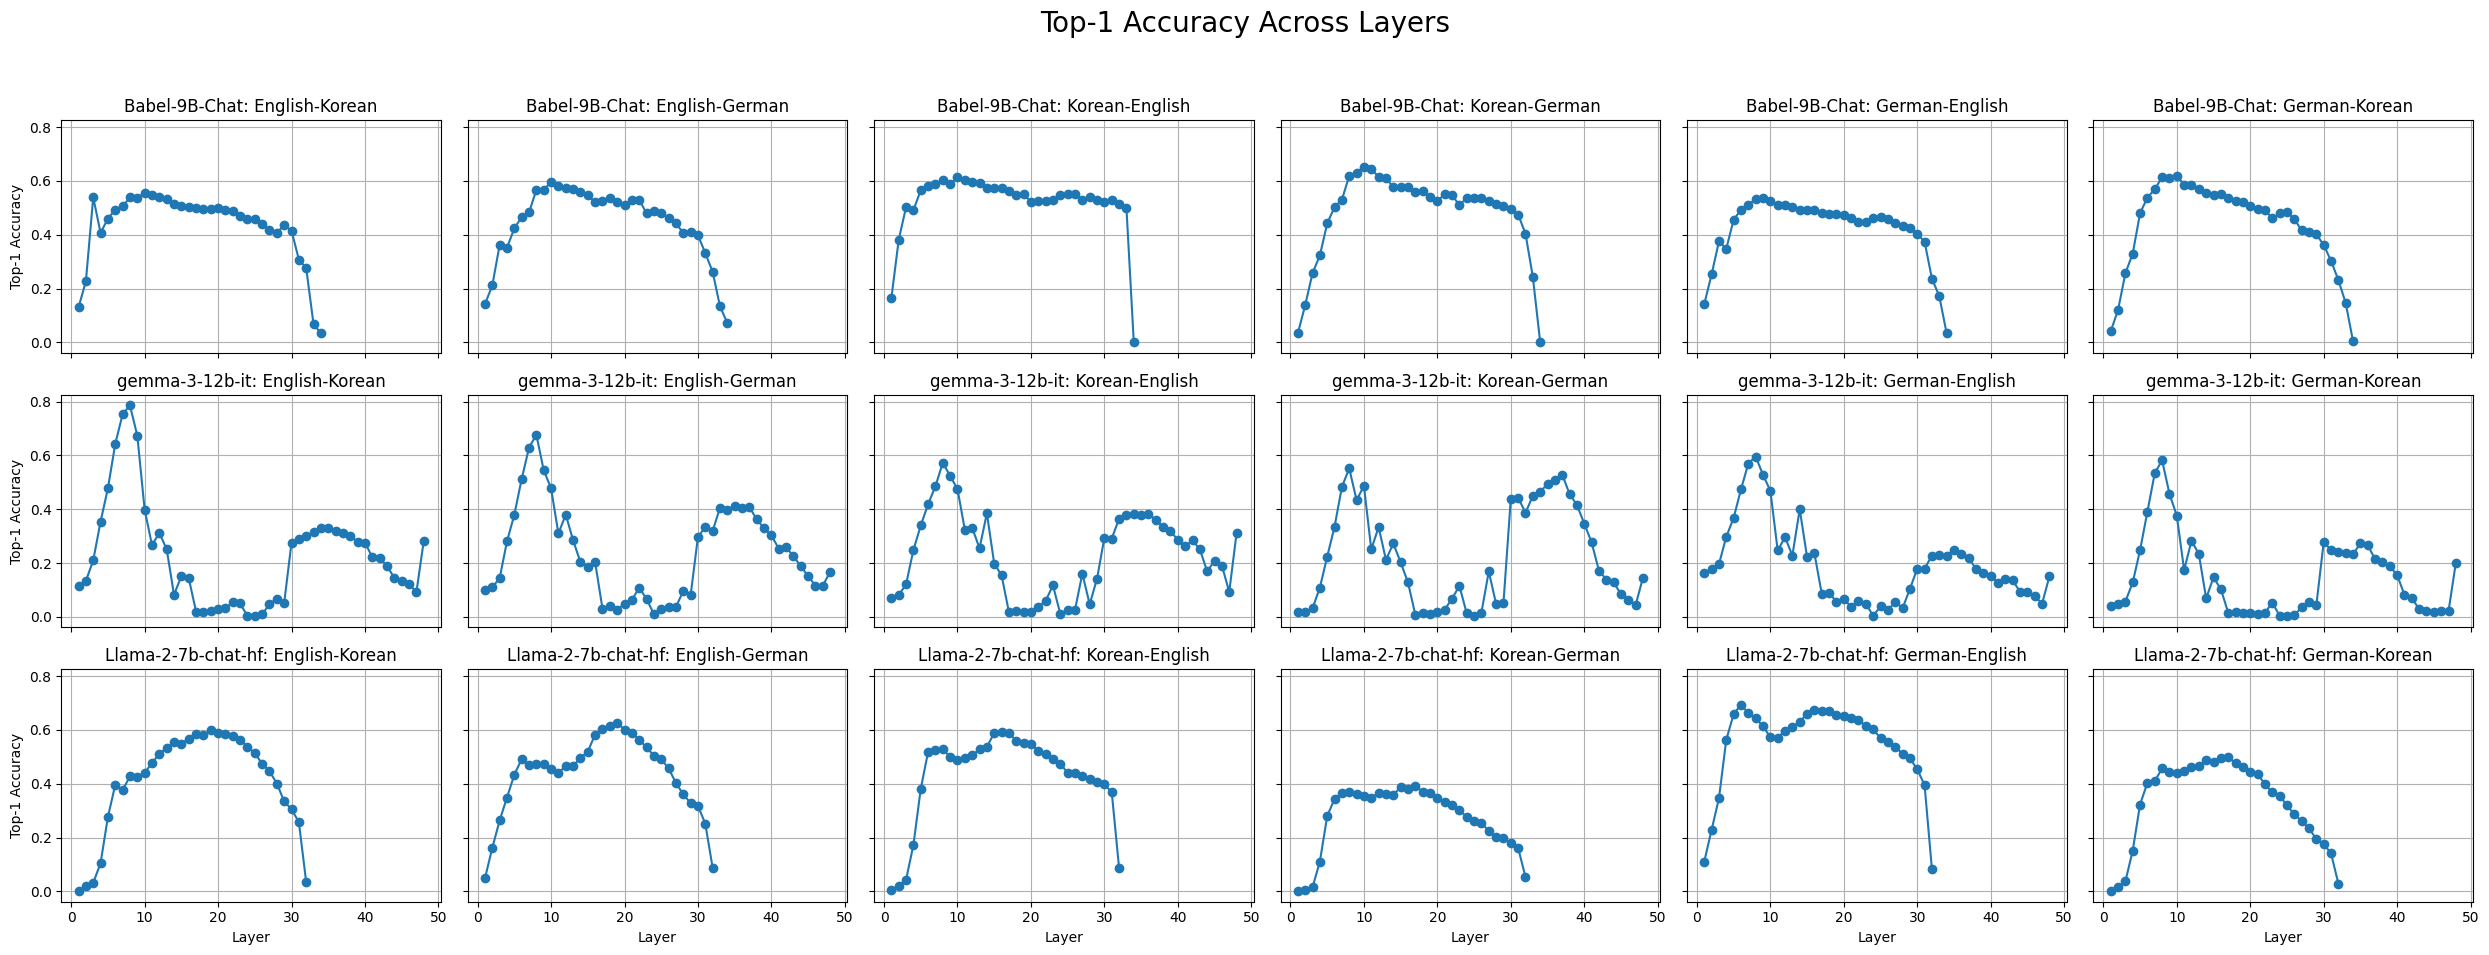

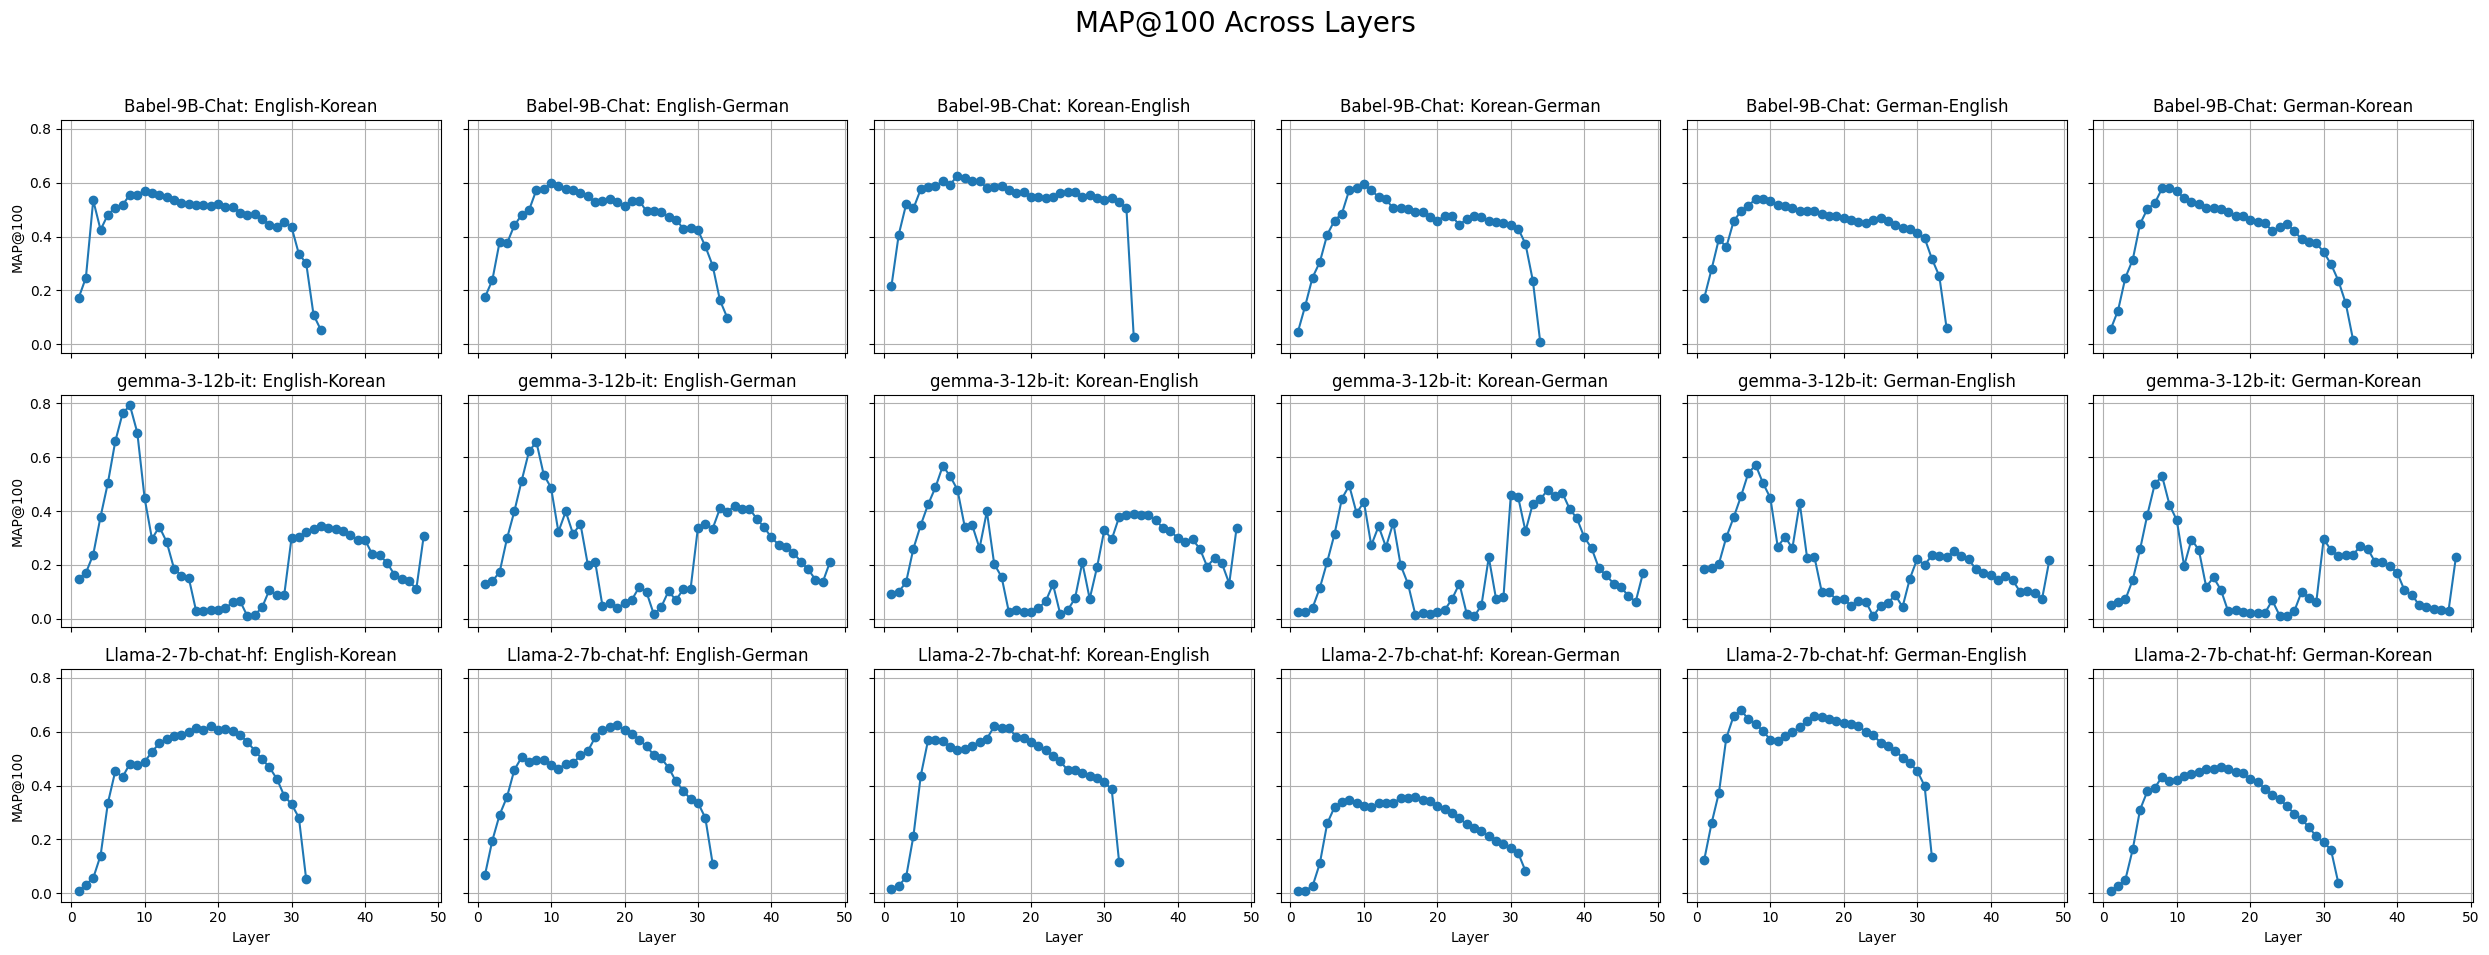

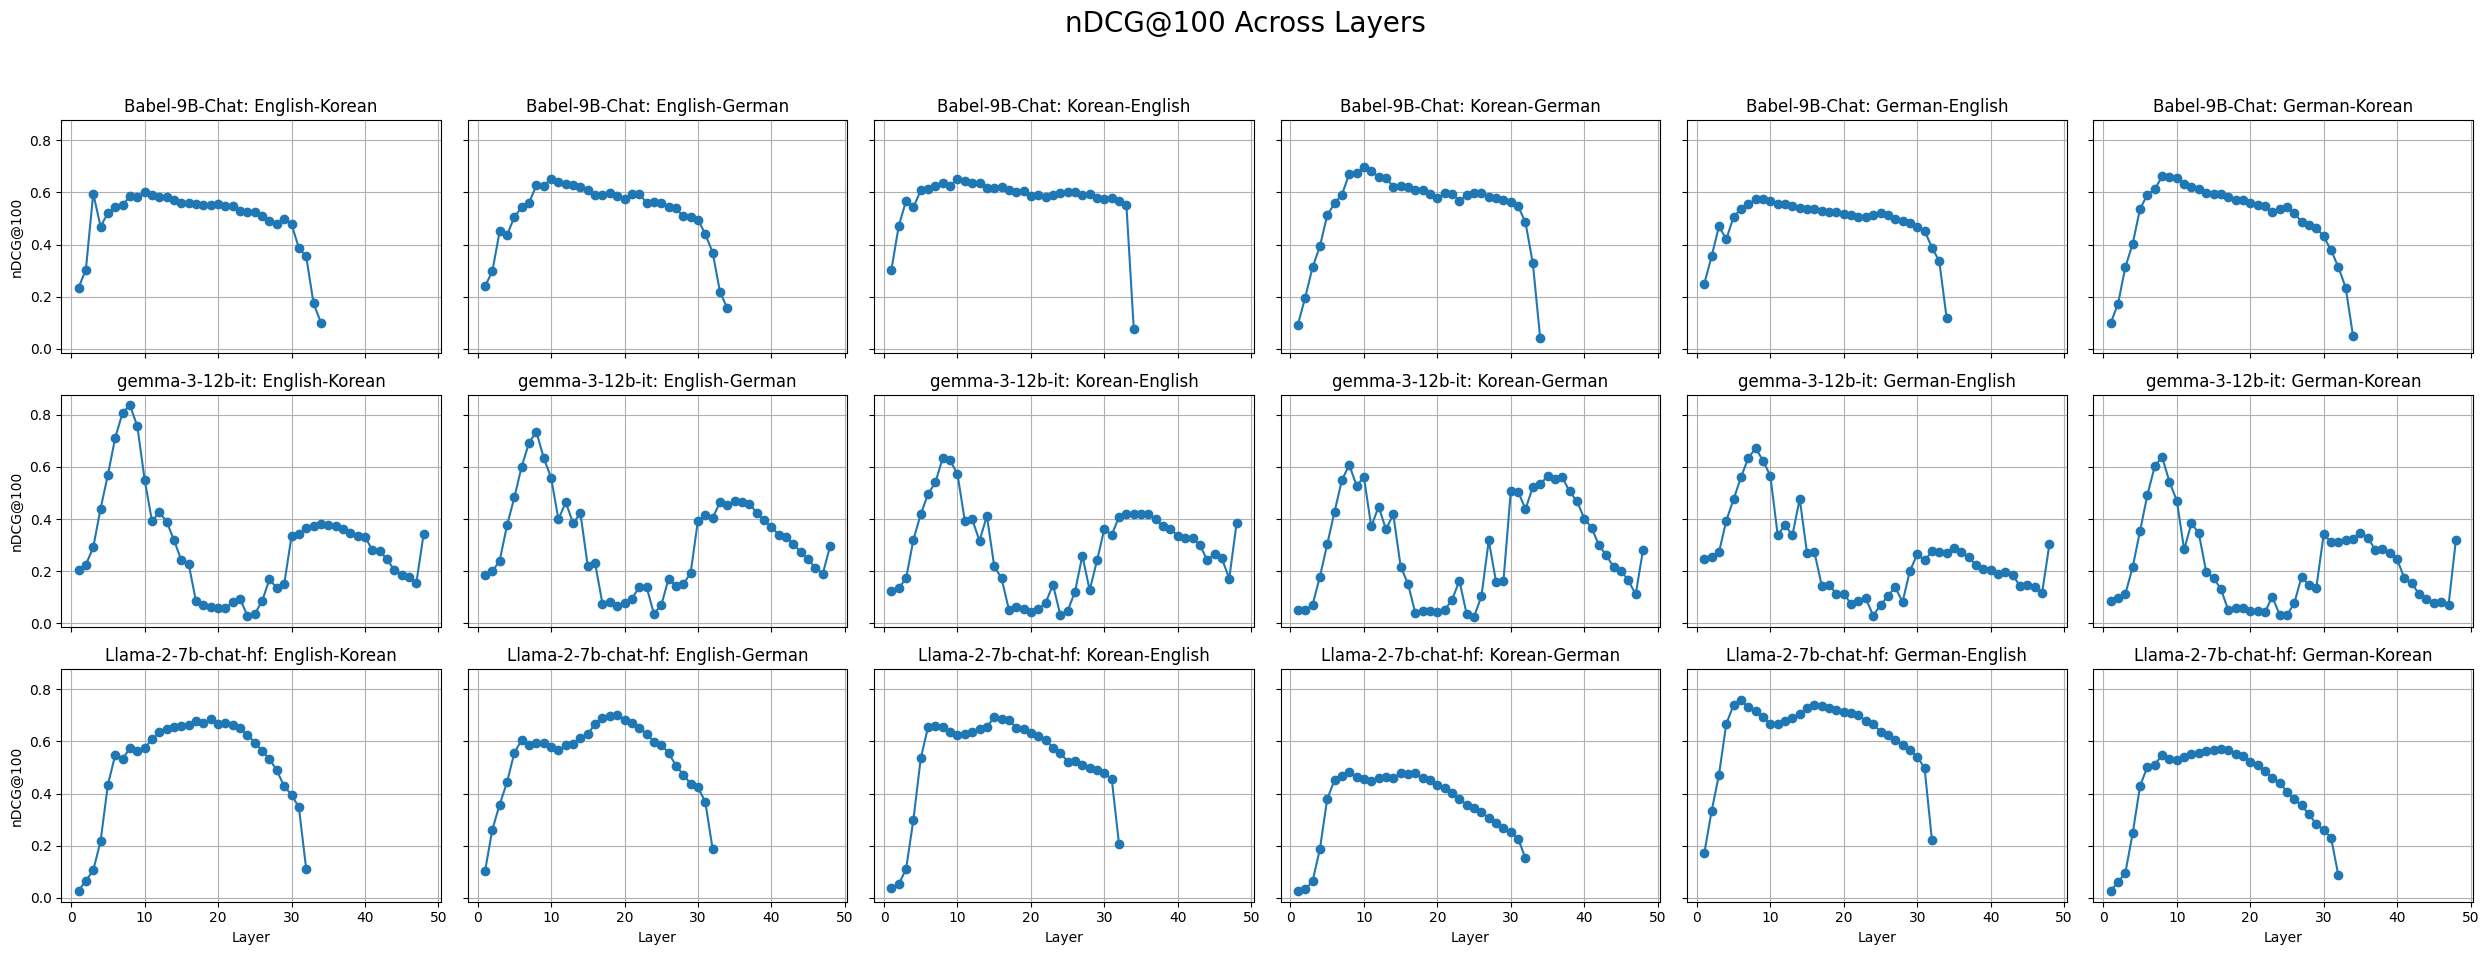

In [3]:
import matplotlib.pyplot as plt

metrics = ["Top-1 Accuracy", "MAP@100", "nDCG@100"]

for metric in metrics:
    fig, axes = plt.subplots(len(models), len(language_pairs), figsize=(25, 10), sharex=True, sharey=True)
    fig.suptitle(f"{metric} Across Layers", fontsize=20)

    for i, model_name in enumerate(models):
        for j, (src, tgt) in enumerate(language_pairs):
            ax = axes[i, j]
            key = f"{src}-{tgt}"
            if key in results_dict[model_name]:
                layer_metrics = results_dict[model_name][key]
                layers = layer_metrics["Layer"]
                values = layer_metrics[metric]

                ax.plot(layers, values, marker='o', label=metric)
                ax.set_title(f"{model_name.split('/')[-1]}: {src}-{tgt}")
                ax.grid(True)

            if i == len(models) - 1:
                ax.set_xlabel("Layer")
            if j == 0:
                ax.set_ylabel(metric)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for title
    plt.show()


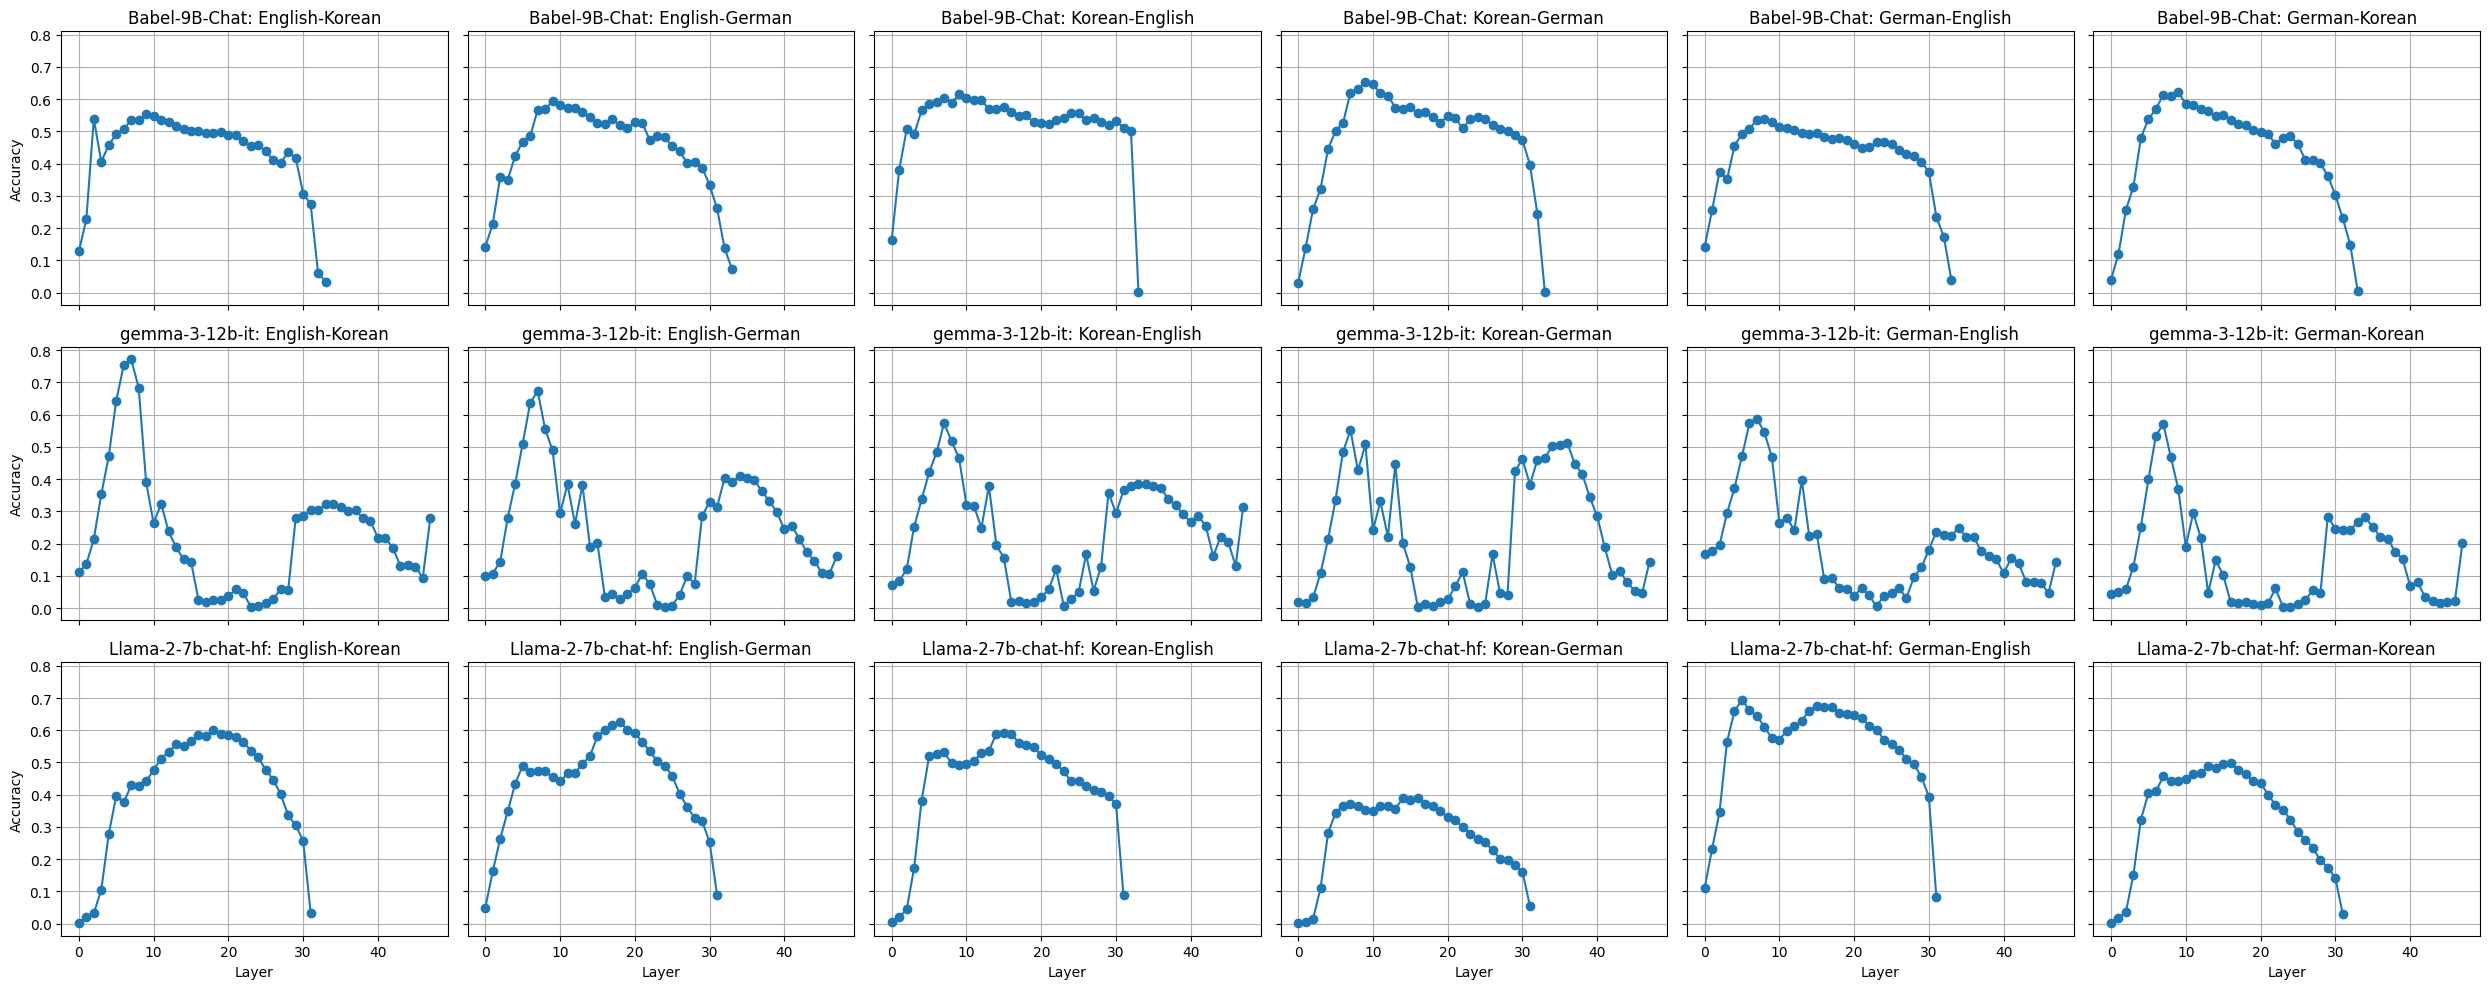

In [14]:
# Visualization
fig, axes = plt.subplots(len(models), len(language_pairs), figsize=(25, 10), sharex=True, sharey=True)

for i, model_name in enumerate(models):
    for j, (src, tgt) in enumerate(language_pairs):
        ax = axes[i, j]
        if f"{src}-{tgt}" in results_dict[model_name]:
            accuracies = results_dict[model_name][f"{src}-{tgt}"]
            layers = list(range(len(accuracies)))

            ax.plot(layers, accuracies, marker='o')
            ax.set_title(f"{model_name.split('/')[-1]}: {src}-{tgt}")
            ax.grid(True)

        if i == len(models) - 1:
            ax.set_xlabel("Layer")
        if j == 0:
            ax.set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

Using device: cuda


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model Tower-Babel/Babel-9B-Chat for Korean loaded successfully.


Extracting hidden states: 100%|██████████| 1690/1690 [00:52<00:00, 32.32it/s]


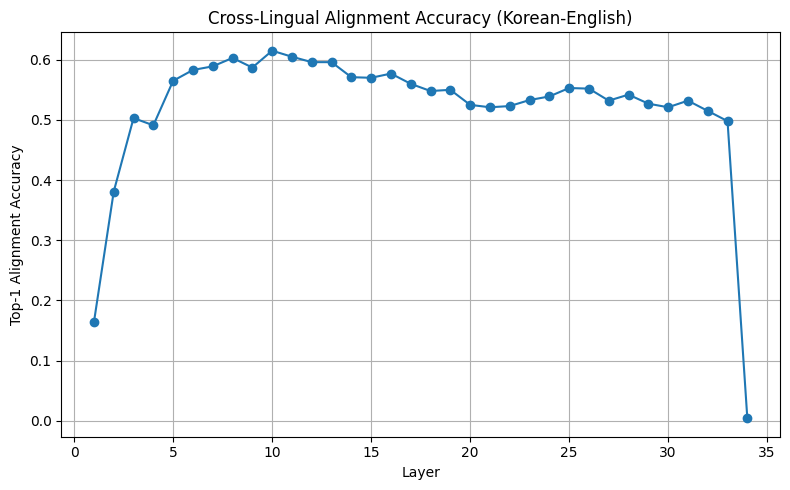

In [ ]:
import sys
import os

# Step 1: Prepare the Dataset
SOURCE_LANGUAGE = "Korean"
TARGET_LANGUAGE = "English"
model_name = "Tower-Babel/Babel-9B-Chat"

def prepare_dataset(SOURCE_LANGUAGE, TARGET_LANGUAGE):
    data_df = pd.read_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ2/MUSE/{SOURCE_LANGUAGE}_{TARGET_LANGUAGE}_1000.csv")
    data_df[TARGET_LANGUAGE] = data_df[TARGET_LANGUAGE].apply(literal_eval)  # Convert string lists to actual lists
    return data_df

dataset_en_ko = prepare_dataset(SOURCE_LANGUAGE, TARGET_LANGUAGE)
source_words_list = dataset_en_ko[SOURCE_LANGUAGE].tolist()
target_words_list = list(set([item for sublist in dataset_en_ko[TARGET_LANGUAGE] for item in sublist]))

# Step 2: Extract Hidden States
module = WordNonwordClassifier(SOURCE_LANGUAGE, model_name)
hidden_source = module.extract_token_i_hidden_states(inputs=source_words_list)
hidden_target = module.extract_token_i_hidden_states(inputs=target_words_list)

# Step 3: Compute Cosine Similarity and Check Alignment

top_k = 1
alignment_results = compute_alignment(hidden_source, hidden_target, dataset_en_ko, top_k=top_k)

# Step 4: Visualize Results
layers = sorted(alignment_results.keys())
accuracies = [alignment_results[layer] for layer in layers]

plt.figure(figsize=(8, 5))
plt.plot(layers, accuracies, marker='o')
plt.xlabel("Layer")
plt.ylabel(f"Top-{top_k} Alignment Accuracy")
plt.title(f"Cross-Lingual Alignment Accuracy ({SOURCE_LANGUAGE}-{TARGET_LANGUAGE})")
plt.grid(True)
plt.tight_layout()
plt.show()